<a href="https://colab.research.google.com/github/willkakuta/Cases_DNC/blob/main/Case_Clusterizacao_Dinamica_day10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome:

Willian Kakuta - 29018

Importando as bibliotecas

In [6]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

Importando os dados

In [7]:
df = pd.read_csv('/content/ecommerce.csv', sep=';', encoding='latin1')
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021
1,536366,HAND WARMER UNION JACK,06/06/2021 08:28,6,1.85,17850.0,16/08/2021
2,536367,ASSORTED COLOUR BIRD ORNAMENT,06/06/2021 08:34,32,1.69,13047.0,14/05/2022
3,536368,JAM MAKING SET WITH JARS,06/06/2021 08:34,6,4.25,13047.0,14/05/2022
4,536369,BATH BUILDING BLOCK WORD,06/06/2021 08:35,3,5.95,13047.0,14/05/2022


Data Understanding

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_pedido       25832 non-null  object 
 1   descricao       24378 non-null  object 
 2   data_pgto       25832 non-null  object 
 3   quantidade      25832 non-null  int64  
 4   preco_unitario  25832 non-null  float64
 5   id_cliente      22190 non-null  float64
 6   ultima_compra   25832 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [9]:
df['data_pgto'] = pd.to_datetime(df.data_pgto, format = '%d/%m/%Y %H:%M')

In [10]:
df.isna().sum()

id_pedido            0
descricao         1454
data_pgto            0
quantidade           0
preco_unitario       0
id_cliente        3642
ultima_compra        0
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df['ultima_compra'] = pd.to_datetime(df.ultima_compra, format = '%d/%m/%Y')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_pedido       22190 non-null  object        
 1   descricao       22190 non-null  object        
 2   data_pgto       22190 non-null  datetime64[ns]
 3   quantidade      22190 non-null  int64         
 4   preco_unitario  22190 non-null  float64       
 5   id_cliente      22190 non-null  float64       
 6   ultima_compra   22190 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 1.4+ MB


In [14]:
df.describe(percentiles=[.25,.50,.75,.80,.90,.98])

,quantidade,preco_unitario,id_cliente
count,22190.000000,22190.000000,22190.000000
mean,18.383867,11.985803,15238.498738
std,28.162886,293.318277,1733.149624
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13755.000000
50%,8.000000,2.100000,15136.000000
75%,20.000000,4.950000,16746.000000
80%,24.000000,5.950000,17068.000000
90%,48.000000,8.500000,17696.000000
98%,120.000000,18.136400,18160.220000


Data Preparation

In [15]:
df['id_cliente'] = df['id_cliente'].astype('category')

In [16]:
df.duplicated().sum()

0

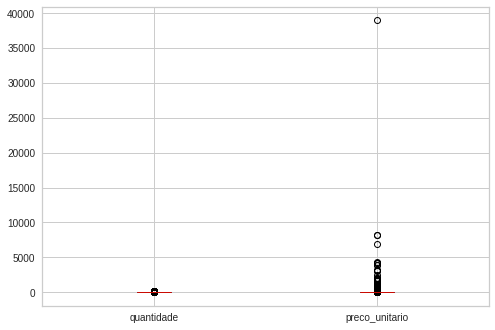

In [17]:
df.plot.box()

In [18]:
df = df.query('preco_unitario<18')

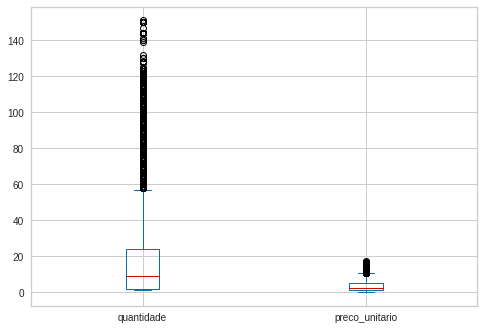

In [19]:
df.plot.box()

In [20]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,2021-08-16
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850.0,2021-08-16
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047.0,2022-05-14
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047.0,2022-05-14
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047.0,2022-05-14


In [21]:
df['R'] = (pd.Timestamp('2023-01-08') - df['ultima_compra']).dt.days

<ipython-input-21-e988dec88f34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R'] = (pd.Timestamp('2023-01-08') - df['ultima_compra']).dt.days


In [22]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra,R
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,2021-08-16,510
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850.0,2021-08-16,510
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047.0,2022-05-14,239
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047.0,2022-05-14,239
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047.0,2022-05-14,239


In [23]:
df['preco_total'] = df['preco_unitario'] * df['quantidade']

<ipython-input-23-478e751250d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preco_total'] = df['preco_unitario'] * df['quantidade']


In [24]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra,R,preco_total
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,2021-08-16,510,15.30
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850.0,2021-08-16,510,11.10
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047.0,2022-05-14,239,54.08
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047.0,2022-05-14,239,25.50
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047.0,2022-05-14,239,17.85


In [25]:
df_rfv = df.copy()

In [28]:
df_rfv.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra,R,preco_total
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,2021-08-16,510,15.30
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850.0,2021-08-16,510,11.10
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047.0,2022-05-14,239,54.08
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047.0,2022-05-14,239,25.50
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047.0,2022-05-14,239,17.85


In [29]:
df_rfv = (
    df.groupby('id_cliente')
    .agg(
        R = ('ultima_compra', lambda x: (pd.Timestamp.today()- x.max()).days),
        F= ('id_pedido', 'nunique'),
        V = ('preco_total', 'mean')
    )
)

df_rfv

,R,F,V
id_cliente,,,
12346.0,533.0,2,14.040000
12347.0,210.0,7,23.308571
12348.0,283.0,4,82.840000
12349.0,226.0,1,15.000000
12350.0,518.0,1,25.200000
...,...,...,...
18280.0,485.0,1,23.700000
18281.0,388.0,1,5.040000
18282.0,215.0,3,15.166667


In [30]:
df_rfv.describe(percentiles=[.25,.50,.75,.80,.90,.95])

,R,F,V
count,4342.000000,4372.000000,4342.000000
mean,299.135421,4.958143,32.504711
std,100.480257,9.048300,49.277961
min,208.000000,0.000000,0.000000
25%,224.000000,1.000000,11.700000
50%,258.000000,3.000000,18.058333
75%,349.000000,5.000000,34.047857
80%,385.000000,6.000000,40.608774
90%,470.000000,11.000000,69.468000
95%,520.000000,16.000000,106.200000


In [31]:
df_rfv.query('V==1224')

,R,F,V
id_cliente,,,
13829.0,567.0,1,1224.0


In [32]:
df.query('id_cliente==13829.0')

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra,R,preco_total
1536,C539055,NOVELTY BISCUITS CAKE STAND 3 TIER,2021-06-20 16:36:00,144,8.5,13829.0,2021-06-20,567,1224.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


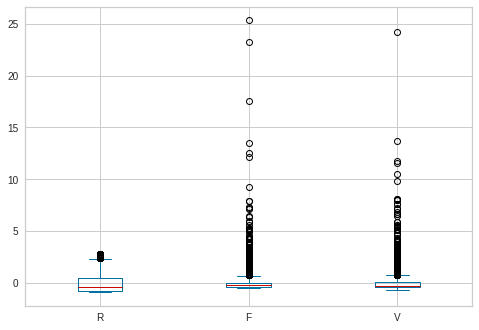

In [33]:
df_rfv.apply(scale).plot.box()

In [34]:
df_rfv = df_rfv.query('F<16')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


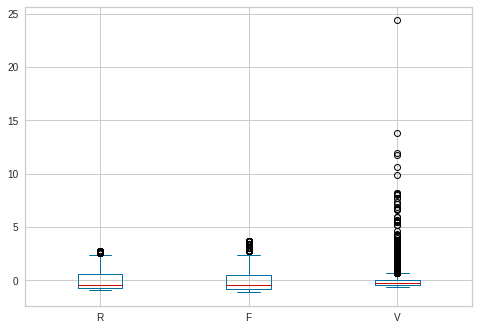

In [35]:
df_rfv.apply(scale).plot.box()

In [36]:
df_rfv = df_rfv.query('V<106')

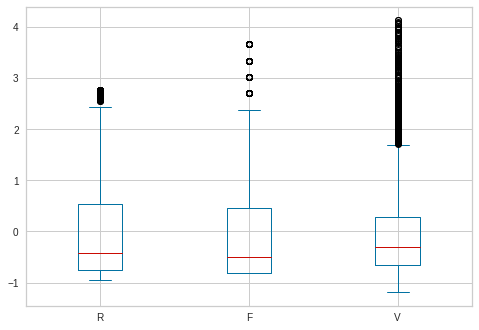

In [37]:
df_rfv.apply(scale).plot.box()

In [38]:
df_rfv_scaled = df_rfv.apply(scale)

Data Modeling

In [43]:
X = df_rfv_scaled.copy()

In [44]:
model = DBSCAN()
labels = model.fit_predict(X)

In [45]:
px.scatter_3d(X, x='R', y='F', z='V', color=labels, template='plotly_dark')

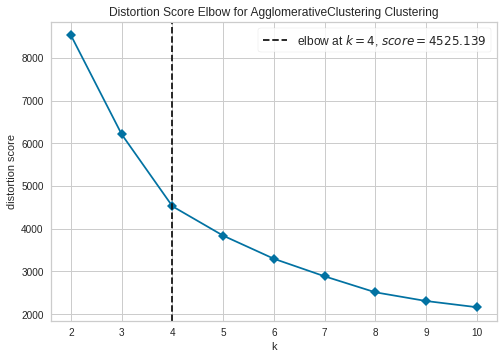

In [46]:
kelbow_visualizer(AgglomerativeClustering(), df_rfv_scaled, k = 10 , timings = False);

In [47]:
model = AgglomerativeClustering(n_clusters=4)
hclust_labels = model.fit_predict(df_rfv_scaled)

In [48]:
px.scatter_3d(df_rfv_scaled, x='R', y='F', z='V', color=hclust_labels, template='plotly_dark')

In [49]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfv_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.310435,1.090334,1486.007215
3,0.363518,1.237880,1750.227106
4,0.384692,0.893067,2085.588503
5,0.296973,1.066569,2018.562966
6,0.303359,1.054137,2007.275272
7,0.282458,1.079568,2002.891318
8,0.293434,1.057737,2054.964324
9,0.295106,1.035464,1999.155972
10,0.260216,1.079659,1924.828264


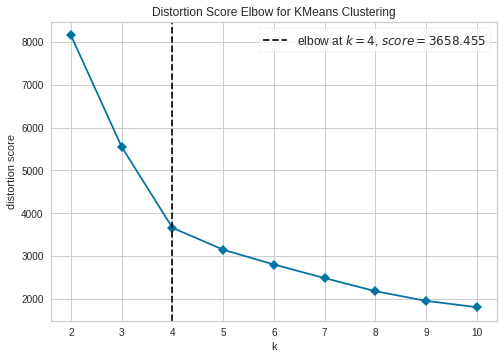

In [50]:
kelbow_visualizer(KMeans(), df_rfv_scaled, k = 10 , timings = False);

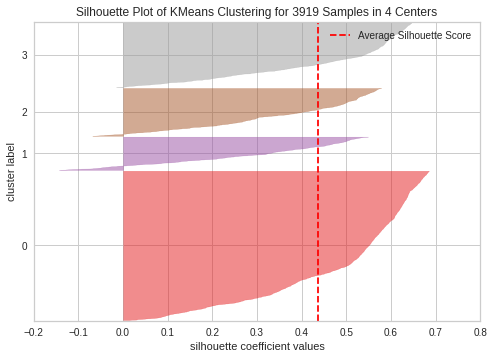

In [51]:
silhouette_visualizer(KMeans(n_clusters=4), df_rfv_scaled);

In [52]:
model = KMeans(n_clusters=4)
model.fit(df_rfv_scaled)

KMeans(n_clusters=4)

In [53]:
centroids = model.cluster_centers_
labels = model.labels_
inertia = model.inertia_

In [54]:
px.scatter_3d(df_rfv_scaled, x='R', y='F', z='V', color=labels, template='plotly_dark')

In [55]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfv_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8151.218750,0.354908,1.095326,1732.728024
3,5546.403367,0.390415,1.043406,2192.478595
4,3658.443953,0.435960,0.795691,2888.830425
5,3147.040374,0.358276,0.925375,2677.103125
6,2801.482919,0.357913,0.941752,2501.751195
7,2483.589237,0.364486,0.913775,2434.488886
8,2182.779303,0.348335,0.938022,2450.804447
9,1952.014186,0.352521,0.934525,2454.999572
10,1804.331657,0.316768,0.966182,2395.787198


In [56]:
parameters={
    'n_init': [5,10,15],
    'max_iter': [200,300,400],
    'algorithm': ['lloyd', 'elkan', 'full']
}

clf = GridSearchCV(KMeans(), parameters, cv=5)
clf.fit(X)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 678, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py", line 1146, in fit
    self._check_params(X)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py", line 956, in _check_params
    raise ValueError(
ValueError: Algorithm must be 'auto', 'full' or 'elkan', got lloyd instead.


/u

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'algorithm': ['lloyd', 'elkan', 'full'],
                         'max_iter': [200, 300, 400], 'n_init': [5, 10, 15]})

In [57]:
clf.best_params_

{'algorithm': 'full', 'max_iter': 300, 'n_init': 5}

In [58]:
model = KMeans(n_clusters=4, max_iter=200, algorithm='full', n_init=5)
model.fit(df_rfv_scaled)

KMeans(algorithm='full', max_iter=200, n_clusters=4, n_init=5)

In [59]:
centroids = model.cluster_centers_
labels = model.labels_
inertia = model.inertia_

In [60]:
px.scatter_3d(df_rfv_scaled, x='R', y='F', z='V', color=labels, template='plotly_dark')

In [61]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfv_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, max_iter=200, algorithm='full', n_init=5)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8151.218750,0.354908,1.095326,1732.728024
3,5546.398779,0.390522,1.043406,2192.477980
4,3658.468658,0.436183,0.794774,2888.817487
5,3147.111714,0.357392,0.930857,2677.048879
6,2801.724758,0.357848,0.940064,2501.477780
7,2483.686733,0.364648,0.914043,2434.463408
8,2178.357240,0.348485,0.923354,2456.784545
9,1952.193174,0.352706,0.931061,2454.739933
10,1803.984883,0.316805,0.971653,2396.369279


In [62]:
centers = pd.DataFrame(model.cluster_centers_, columns=df_rfv_scaled.columns)

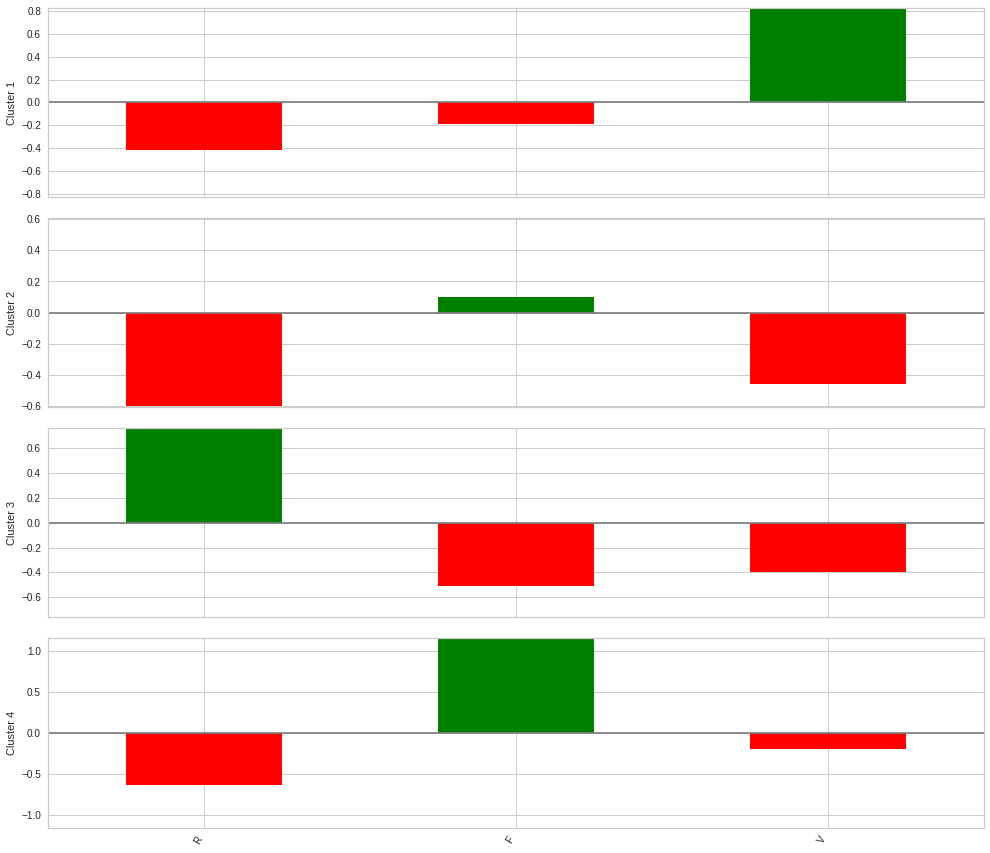

In [63]:
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

1 - Qual método que se encaixa no modelo?

De acordo com as analises, testamos 3 modelos de clusterização e o que apresentou uma performance maior foi o K Means. Com isso, tunamos o modelo com Grid Search e notamos que esses são os melhores parametros apresentados.

2 - Quais possíveis abordagens podem ser tomadas de acordo com a analise?

Identificamos que o cluster 1 são os clientes que tem a maior recência, ou seja, clientes que não compram a mais tempo. 

No cluster 2, identificamos que seriam um grupo de clientes novos com o ticket médio baixo.

No cluster 3, são os clientes que mais gastaram e alguns são compras recentes.

No cluster 4, são clientes que compram mais vezes.